In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

In [3]:
import pickle
from datatools import wfip2
from datatools.remote_sensing import ESRL_wind_profiler
from datatools.metmast import EddyPro_full_output, load_sonic_data
from abl.meteorology import fit_power_law_alpha

In [4]:
plt.style.use('seaborn-darkgrid')

# WFIP2/MMC Case  (2016-11-21) : simulation setup
* "CBS-": cross-barrier synoptic
* mountain waves
* topographic wakes

power ramp event "VOL"

In [5]:
starttime = pd.datetime(2016,11,21,17,0,0)
#endtime = pd.datetime(2016,11,22,4,0,0)
endtime = pd.datetime(2016,11,22,4,1,0)  # radar data collection slightly offset from the hour

simstart = pd.datetime(2016,11,21,22,0,0)
simend = pd.datetime(2016,11,21,23,0,0)

tsample = pd.datetime(2016,11,21,22,30,0)

In [6]:
wasco_elev = 456.0
# ps01_elev = 428.0
# ps02_elev = 445.0
# ps06_elev = 474.0
# ps11_elev = 484.0
# ps12_elev = 495.0

In [7]:
def format_time_axis(ax):
    if not hasattr(ax,'__iter__'):
        ax = [ax]
    # axis labels
    ax[0].xaxis.set_major_locator(mdates.DayLocator())
    ax[0].xaxis.set_minor_locator(mdates.HourLocator())
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('\n%Y-%m-%d'))
    ax[0].xaxis.set_minor_formatter(mdates.DateFormatter('%HZ'))
    # simulation period indicator
    ax[0].axvline(simstart,color='k',ls='--')
    ax[0].axvline(simend,color='k',ls='--')
    if len(ax) > 1:
        ax[1].axvline(simstart,color='k',ls='--')
        ax[1].axvline(simend,color='k',ls='--')

In [8]:
zhub = 80.

In [9]:
t0 = pd.to_datetime('2016-11-21 22:00')
t1 = pd.to_datetime('2016-11-21 23:00')

## Inflow fields

wasco radar

In [10]:
wasco_dpath = '/Users/equon/WFIP2/Wasco/radar.z04.b0/201611'

In [11]:
%%time
wasco_radar = wfip2.read_dir(dpath=wasco_dpath,
                             reader=ESRL_wind_profiler,
                             ext='.winds',
                             modes=1,check_na=['SPD','DIR','SNR'],na_values=999999)
wasco_radar.rename({'HT':'height','SPD':'speed','DIR':'direction'},axis=1,inplace=True)
wasco_radar['height'] *= 1000
wasco_radar = wasco_radar.sort_values(['date_time','height'])
wasco_radar = wasco_radar.set_index('date_time')

CPU times: user 11.7 s, sys: 192 ms, total: 11.9 s
Wall time: 15.2 s


In [12]:
wasco_radar.columns

Index([u'height', u'speed', u'direction', u'MET_QC', u'RAD.0', u'RAD.1',
       u'RAD.2', u'CNT.0', u'CNT.1', u'CNT.2', u'SNR.0', u'SNR.1', u'SNR.2',
       u'QC.0', u'QC.1', u'QC.2'],
      dtype='object')

heights: [   81.   138.   196.   253.   310.   367.   425.   482.   539.   596.
   653.   711.   768.   825.   882.   939.   997.  1054.  1111.  1168.
  1226.  1283.  1340.  1397.  1454.  1512.  1569.  1626.  1683.  1741.
  1798.  1855.  1912.  1969.  2027.  2084.  2141.  2198.  2255.  2313.
  2370.  2427.  2484.  2542.]
times: DatetimeIndex(['2016-11-21 17:00:01', '2016-11-21 18:00:02',
               '2016-11-21 19:00:02', '2016-11-21 20:00:03',
               '2016-11-21 21:00:04', '2016-11-21 22:00:05',
               '2016-11-21 23:00:06', '2016-11-22 00:00:07',
               '2016-11-22 01:00:08', '2016-11-22 02:00:08',
               '2016-11-22 03:00:09', '2016-11-22 04:00:10'],
              dtype='datetime64[ns]', name=u'date_time', freq=None)


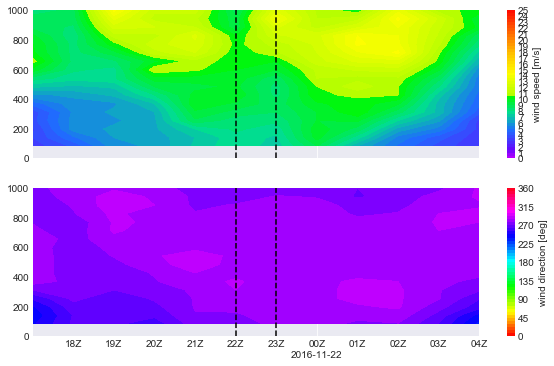

In [13]:
fig,ax = wfip2.plot_wind(wasco_radar, datetime_range=(starttime,endtime),verbose=True)
ax[0].set_ylim((0,1000))
format_time_axis(ax)

PS01 sodar

In [14]:
%%time
ps01_sodar = wfip2.read_dir(dpath='/Users/equon/WFIP2/PS01/sodar.z12.b0/201611',
                            reader=pd.read_csv,
                            ext='txt',
                            parse_dates=['date_time'])
ps01_sodar = ps01_sodar.sort_values(['date_time','height'])
ps01_sodar = ps01_sodar.set_index('date_time')

CPU times: user 9.44 s, sys: 6.8 s, total: 16.2 s
Wall time: 25.2 s


In [15]:
ps01_sodar.columns

Index([u'height', u'direction', u'speed', u'vert', u'turbulence'], dtype='object')

In [16]:
#ps01_sodar.loc[(ps01_sodar.index >= starttime) & (ps01_sodar.index <= endtime),'vert'].plot()

heights: [ 40  50  60  80 100 120 140 160 180 200]
times: DatetimeIndex(['2016-11-21 17:00:00', '2016-11-21 17:10:00',
               '2016-11-21 17:20:00', '2016-11-21 17:30:00',
               '2016-11-21 17:40:00', '2016-11-21 17:50:00',
               '2016-11-21 18:00:00', '2016-11-21 18:10:00',
               '2016-11-21 18:20:00', '2016-11-21 18:30:00',
               '2016-11-21 18:40:00', '2016-11-21 18:50:00',
               '2016-11-21 19:00:00', '2016-11-21 19:10:00',
               '2016-11-21 19:20:00', '2016-11-21 19:30:00',
               '2016-11-21 19:40:00', '2016-11-21 19:50:00',
               '2016-11-21 20:00:00', '2016-11-21 20:10:00',
               '2016-11-21 20:20:00', '2016-11-21 20:30:00',
               '2016-11-21 20:40:00', '2016-11-21 20:50:00',
               '2016-11-21 21:00:00', '2016-11-21 21:10:00',
               '2016-11-21 21:20:00', '2016-11-21 21:30:00',
               '2016-11-21 21:40:00', '2016-11-21 21:50:00',
               '2016-11-21 

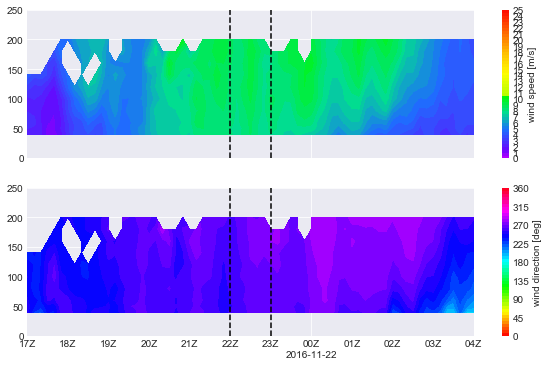

In [17]:
fig,ax = wfip2.plot_wind(ps01_sodar, datetime_range=(starttime,endtime),verbose=True)
ax[0].set_ylim((0,250))
format_time_axis(ax)

In [18]:
zfit = np.array([50,60,80])
Ufit = ps01_sodar.pivot(columns='height',values='speed')[zfit]

alpha = []
R2 = []
Ufit = Ufit.loc[(Ufit.index >= t0) & (Ufit.index <= t1)]
for i in range(len(Ufit)):
    Ufit_i = Ufit.iloc[i].values
    print Ufit_i
    if np.any(np.isnan(Ufit_i)):
        fit = [np.nan, 0]
    else:
        fit = fit_power_law_alpha(zfit, Ufit_i, zref=zhub, Uref=Ufit_i[-1])
    alpha.append(fit[0])
    R2.append(fit[1])
tfit_ps01 = Ufit.index
alpha_ps01 = np.array(alpha)
print 'R2:',np.min(R2), np.max(R2)

[ 8.02  8.17  8.34]
[ 7.61  7.8   7.87]
[ 8.11  8.26  8.27]
[ 8.59  8.59  8.86]
[ 8.03  8.03  8.22]
[ 7.65  7.76  7.84]
[ 8.22  8.15  8.51]
R2: 0.648200053373 0.989469456486


PS12 lidar

In [19]:
%%time
ps12_lidar = pd.read_csv('Siemens/Siemens_Nov2016_10min.csv',parse_dates=['datetime'])
ps12_lidar = ps12_lidar.sort_values(['datetime','height'])
ps12_lidar = ps12_lidar.set_index('datetime')

CPU times: user 102 ms, sys: 16.4 ms, total: 118 ms
Wall time: 122 ms


In [20]:
ps12_lidar.columns

Index([u'height', u'speed', u'direction', u'TI'], dtype='object')

In [21]:
np.unique(ps12_lidar['height'])

array([ 50,  65,  75,  80, 100, 125, 150, 175, 200, 225, 250, 275, 300, 400])

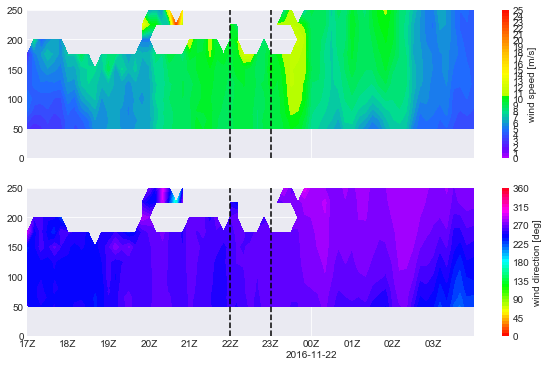

In [22]:
fig,ax = wfip2.plot_wind(ps12_lidar, datetime_range=(starttime,endtime))
ax[0].set_ylim((0,250))
format_time_axis(ax)

In [23]:
zfit = np.array([50,65,75,80])
Ufit = ps12_lidar.pivot(columns='height',values='speed')[zfit]

alpha = []
R2 = []
Ufit = Ufit.loc[(Ufit.index >= t0) & (Ufit.index <= t1)]
for i in range(len(Ufit)):
    Ufit_i = Ufit.iloc[i].values
    print Ufit_i
    if np.any(np.isnan(Ufit_i)):
        fit = [np.nan, 0]
    else:
        fit = fit_power_law_alpha(zfit, Ufit_i, zref=zhub, Uref=Ufit_i[-1])
    alpha.append(fit[0])
    R2.append(fit[1])

tfit_ps12 = Ufit.index
alpha_ps12 = np.array(alpha)
print 'R2:', np.min(R2), np.max(R2)

[ 9.4493  9.4702  9.3968  9.4271]
[ 9.2831  9.0422  9.2377  9.2932]
[ 9.3183  9.1859  9.1795  9.2571]
[ 8.4064  8.3829  8.3374  8.4335]
[ 9.0956  9.1207  9.009   8.9337]
[ 9.2419  9.2286  9.3212  9.4058]
R2: -2.05753239482 0.391853584204


## met data reader

In [24]:
columns=[
    'wind_speed','wind_dir','sonic_temperature','u*','w/ts_cov'
    #'air_temperature','air_pressure','RH','specific_humidity'
]

In [25]:
def eddypro_height_wrapper(dpath,prefix,heights,*args,**kwargs):
    """call read_eddypro, i.e., RM Young sonic data postprocessed using
    EddyPro, for different heights
    """
    dflist = []
    for h in heights:
        df = wfip2.read_dir(dpath=dpath,
                            reader=EddyPro_full_output,
                            prefix=prefix,
                            ext='.son{:02d}m.full_output.csv'.format(int(h)),
                            columns=columns)
        df['height'] = h
        dflist.append(df)
    return pd.concat(dflist)

## estimate target wind speed profile
at tsample, 22:30 UTC (2:30 pm, local) or averaged over one hour (22-23Z)

met stations

In [26]:
%%time
z01 = np.array([3.0,10.0])
ps01 = eddypro_height_wrapper('PS01/met.z18.b0',
                              prefix='met.z18.b0.2016112',
                              heights=z01)

CPU times: user 553 ms, sys: 166 ms, total: 719 ms
Wall time: 1.87 s


In [27]:
%%time
z02 = np.array([3.0,10.0,17.0])
ps02 = eddypro_height_wrapper('PS02/met.z19.b0',
                              prefix='met.z19.b0.2016112',
                              heights=z02)

CPU times: user 858 ms, sys: 248 ms, total: 1.11 s
Wall time: 2.89 s


In [28]:
%%time
z06 = np.array([3.0,10.0,21.0])
ps06 = eddypro_height_wrapper('PS06/met.z21.b0',
                              prefix='met.z21.b0.2016112',
                              heights=z06)

CPU times: user 814 ms, sys: 238 ms, total: 1.05 s
Wall time: 2.75 s


In [29]:
%%time
z11 = np.array([3.0,10.0])
ps11 = eddypro_height_wrapper('PS11/met.z23.b0',
                              prefix='met.z23.b0.2016112',
                              heights=z11)

CPU times: user 571 ms, sys: 167 ms, total: 738 ms
Wall time: 1.97 s


In [30]:
ps11.head()

,speed,direction,temperature,u*,w/ts_cov,height
datetime,,,,,,
2016-11-01 00:15:00,1.625756,305.402754,284.545258,0.199774,-0.006849,3.0
2016-11-01 00:30:00,1.757224,342.166502,284.395755,0.103021,-0.004573,3.0
2016-11-01 00:45:00,2.283966,345.607685,284.170407,0.091265,-0.006483,3.0
2016-11-01 01:00:00,1.904653,350.644560,283.896398,0.032160,-0.004072,3.0
2016-11-01 01:15:00,2.057570,345.993589,283.923893,0.074110,-0.006021,3.0


In [31]:
%%time
PS12_sonic80s = load_sonic_data('/Users/equon/WFIP2/PS12/sonic80s_Nov2016.csv',height=80.0)
PS12_sonic80w = load_sonic_data('/Users/equon/WFIP2/PS12/sonic80w_Nov2016.csv',height=80.0)
PS12_sonic50s = load_sonic_data('/Users/equon/WFIP2/PS12/sonic50s_Nov2016.csv',height=50.0)
PS12_sonic50w = load_sonic_data('/Users/equon/WFIP2/PS12/sonic50w_Nov2016.csv',height=50.0)

t = PS12_sonic80s.index
PS12_sonic80s = PS12_sonic80s.loc[(t >= t0) & (t <= t1)]
t = PS12_sonic80w.index
PS12_sonic80w = PS12_sonic80w.loc[(t >= t0) & (t <= t1)]
t = PS12_sonic50s.index
PS12_sonic50s = PS12_sonic50s.loc[(t >= t0) & (t <= t1)]
t = PS12_sonic50w.index
PS12_sonic50w = PS12_sonic50w.loc[(t >= t0) & (t <= t1)]

z12 = np.array([50.,80.])
ps12s = pd.concat((PS12_sonic50s,PS12_sonic80s))
ps12w = pd.concat((PS12_sonic50w,PS12_sonic80w))

ps12s = ps12s.rename(columns={'z':'height'})
ps12w = ps12w.rename(columns={'z':'height'})

CPU times: user 19 s, sys: 2.64 s, total: 21.7 s
Wall time: 22.8 s


In [32]:
zfit = np.array([50,80])
Ufit50 = PS12_sonic50s.resample('10min').mean()['speed']
Ufit80 = PS12_sonic80s.resample('10min').mean()['speed']
assert(len(Ufit50)==len(Ufit80))
tfit = Ufit50.index

alpha = []
R2 = []
for i,(U50,U80) in enumerate(zip(Ufit50,Ufit80)):
    Ufit_i = np.array([U50,U80])
    print tfit[i], Ufit_i
    if np.any(np.isnan(Ufit_i)):
        fit = [np.nan, 0]
    else:
        fit = fit_power_law_alpha(zfit, Ufit_i, zref=zhub, Uref=Ufit_i[-1])
    alpha.append(fit[0])
    R2.append(fit[1])

alpha_ps12s = np.array(alpha)
print 'R2:', np.min(R2), np.max(R2)

2016-11-21 22:00:00 [ 8.40967914  8.79211194]
2016-11-21 22:10:00 [ 9.36538361  9.83708767]
2016-11-21 22:20:00 [ 9.30996701  9.56048228]
2016-11-21 22:30:00 [ 9.34806436  9.56142098]
2016-11-21 22:40:00 [ 8.27503673  8.54766776]
2016-11-21 22:50:00 [ 9.19849123  9.24595921]
2016-11-21 23:00:00 [ 8.74014874  9.42204861]
R2: 0.999999999997 1.0


In [33]:
zfit = np.array([50,80])
Ufit50 = PS12_sonic50w.resample('10min').mean()['speed']
Ufit80 = PS12_sonic80w.resample('10min').mean()['speed']
assert(len(Ufit50)==len(Ufit80))
tfit = Ufit50.index

alpha = []
R2 = []
for i,(U50,U80) in enumerate(zip(Ufit50,Ufit80)):
    Ufit_i = np.array([U50,U80])
    print tfit[i], Ufit_i
    if np.any(np.isnan(Ufit_i)):
        fit = [np.nan, 0]
    else:
        fit = fit_power_law_alpha(zfit, Ufit_i, zref=zhub, Uref=Ufit_i[-1])
    alpha.append(fit[0])
    R2.append(fit[1])

alpha_ps12w = np.array(alpha)
print 'R2:', np.min(R2), np.max(R2)

2016-11-21 22:00:00 [ 8.33971782  8.70782208]
2016-11-21 22:10:00 [ 9.26459551  9.7197963 ]
2016-11-21 22:20:00 [ 9.18918634  9.44192176]
2016-11-21 22:30:00 [ 9.07225753  9.34325376]
2016-11-21 22:40:00 [ 8.11491916  8.39540727]
2016-11-21 22:50:00 [ 8.95383635  9.09159285]
2016-11-21 23:00:00 [ 9.08542789  9.304644  ]
R2: 0.999999999724 1.0


In [34]:
alpha = pd.DataFrame(
    index=tfit,
    data={
        'PS01':alpha_ps01,
        'PS12s':alpha_ps12s,
        'PS12w':alpha_ps12w,
    }
)
alpha.to_csv('alpha_2016-11-21_2200.csv')

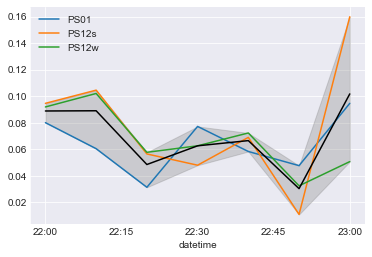

In [35]:
fig,ax = plt.subplots()

alpha.plot(ax=ax)

alphamin = alpha.min(axis=1)
alphamax = alpha.max(axis=1)
alphamean = alpha.mean(axis=1)

alphamean.plot(ax=ax, color='k')
ax.fill_between(alpha.index, alphamin, alphamax, color='0.5',alpha=0.3)

In [36]:
def calc_met_TKE(df):
    var = df.resample('10min').var()
    k = 0.5 * (var['u'] + var['v'] + var['w'])
    return k[~pd.isna(k)]

In [37]:
TKE_ps12s = calc_met_TKE(PS12_sonic80s)
TKE_ps12s

datetime
2016-11-21 22:00:00    0.507853
2016-11-21 22:10:00    0.614890
2016-11-21 22:20:00    0.335192
2016-11-21 22:30:00    0.434423
2016-11-21 22:40:00    0.404566
2016-11-21 22:50:00    0.502179
Freq: 10T, dtype: float64

In [38]:
TKE_ps12w = calc_met_TKE(PS12_sonic80w)
TKE_ps12w

datetime
2016-11-21 22:00:00    0.473417
2016-11-21 22:10:00    0.647048
2016-11-21 22:20:00    0.345137
2016-11-21 22:30:00    0.436836
2016-11-21 22:40:00    0.428464
2016-11-21 22:50:00    0.565552
Freq: 10T, dtype: float64

In [39]:
TKE = pd.DataFrame(
    index=tfit,
    data={
        'PS12s':TKE_ps12s,
        'PS12w':TKE_ps12w,
    }
)
TKE.to_csv('TKE_2016-11-21_2200.csv')

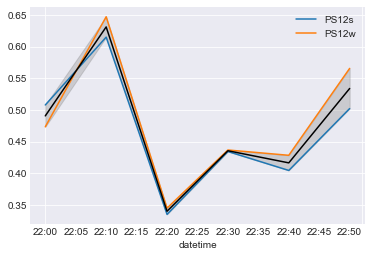

In [40]:
fig,ax = plt.subplots()

TKE.plot(ax=ax)

TKEmin = TKE.min(axis=1)
TKEmax = TKE.max(axis=1)
TKEmean = TKE.mean(axis=1)

TKEmean.plot(ax=ax, color='k')
ax.fill_between(TKE.index, TKEmin, TKEmax, color='0.5',alpha=0.3)

In [41]:
def calc_met_TI(df):
    df['uv'] = df['u'] * df['v']
    mean = df.resample('10min').mean()
    var = df.resample('10min').var()
    ang = np.radians(270. - mean['direction'])
    uu = var['u']
    vv = var['v']
    uv = mean['uv'] - mean['u']*mean['v']
    TI = (uu * np.cos(ang)**2 \
        + uv * 2*np.sin(ang)*np.cos(ang) \
        + vv * np.sin(ang)**2) / mean['speed']
    return TI[~pd.isna(TI)]

In [42]:
TI_ps12s = calc_met_TI(PS12_sonic80s)
TI_ps12s

datetime
2016-11-21 22:00:00    0.055278
2016-11-21 22:10:00    0.058502
2016-11-21 22:20:00    0.030538
2016-11-21 22:30:00    0.060309
2016-11-21 22:40:00    0.043295
2016-11-21 22:50:00    0.045403
Freq: 10T, dtype: float64

In [43]:
TI_ps12w = calc_met_TI(PS12_sonic80w)
TI_ps12w

datetime
2016-11-21 22:00:00    0.050297
2016-11-21 22:10:00    0.059338
2016-11-21 22:20:00    0.029973
2016-11-21 22:30:00    0.054616
2016-11-21 22:40:00    0.045603
2016-11-21 22:50:00    0.045391
Freq: 10T, dtype: float64

In [44]:
inrange = (ps01_sodar.index >= t0) & (ps01_sodar.index <= t1) & (ps01_sodar['height'] == 80)
TI_ps01 = ps01_sodar.loc[inrange,'turbulence']

In [45]:
TI = pd.DataFrame(
    index=tfit,
    data={
        'PS01':TI_ps01,
        'PS12s':TI_ps12s,
        'PS12w':TI_ps12w,
    }
)
TI.to_csv('TI_2016-11-21_2200.csv')

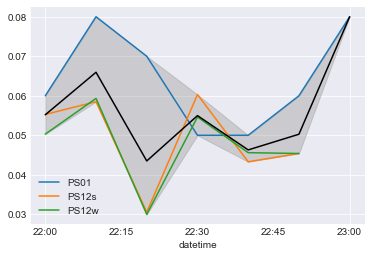

In [46]:
fig,ax = plt.subplots()

TI.plot(ax=ax)

TImin = TI.min(axis=1)
TImax = TI.max(axis=1)
TImean = TI.mean(axis=1)

TImean.plot(ax=ax, color='k')
ax.fill_between(TI.index, TImin, TImax, color='0.5',alpha=0.3)

remote sensing

In [47]:
zradar, Uradar = wfip2.get_profile_at_time(wasco_radar, time=tsample, field='speed')
zradar, WDradar = wfip2.get_profile_at_time(wasco_radar, time=tsample, field='direction')

In [48]:
#zsodar, Usodar = wfip2.get_profile_at_time(ps01_sodar, time=tsample, field='speed')
zsodar, Usodar = wfip2.average_profile_over_times(ps01_sodar, (simstart,simend), field='speed')
zsodar, WDsodar = wfip2.average_profile_over_times(ps01_sodar, (simstart,simend), field='direction',verbose=False)

Average over 7 DatetimeIndex(['2016-11-21 22:00:00', '2016-11-21 22:10:00',
               '2016-11-21 22:20:00', '2016-11-21 22:30:00',
               '2016-11-21 22:40:00', '2016-11-21 22:50:00',
               '2016-11-21 23:00:00'],
              dtype='datetime64[ns]', name=u'date_time', freq=None)


In [49]:
#zlidar, Ulidar = wfip2.get_profile_at_time(ps12_lidar, time=tsample, field='speed')
zlidar, Ulidar = wfip2.average_profile_over_times(ps12_lidar, (simstart,simend), field='speed')
zlidar, WDlidar = wfip2.average_profile_over_times(ps12_lidar, (simstart,simend), field='direction',verbose=False)

Average over 6 DatetimeIndex(['2016-11-21 22:10:00', '2016-11-21 22:19:59',
               '2016-11-21 22:30:00', '2016-11-21 22:40:00',
               '2016-11-21 22:49:59', '2016-11-21 23:00:00'],
              dtype='datetime64[ns]', name=u'datetime', freq=None)


In [50]:
_, Ups01 = wfip2.average_profile_over_times(ps01, (simstart,simend), field='speed')
_, WDps01 = wfip2.average_profile_over_times(ps01, (simstart,simend), field='direction', verbose=False)

Average over 5 DatetimeIndex(['2016-11-21 22:00:00', '2016-11-21 22:15:00',
               '2016-11-21 22:30:00', '2016-11-21 22:45:00',
               '2016-11-21 23:00:00'],
              dtype='datetime64[ns]', name=u'datetime', freq=None)


In [51]:
_, Ups02 = wfip2.average_profile_over_times(ps02, (simstart,simend), field='speed')
_, WDps02 = wfip2.average_profile_over_times(ps02, (simstart,simend), field='direction', verbose=False)

Average over 5 DatetimeIndex(['2016-11-21 22:00:00', '2016-11-21 22:15:00',
               '2016-11-21 22:30:00', '2016-11-21 22:45:00',
               '2016-11-21 23:00:00'],
              dtype='datetime64[ns]', name=u'datetime', freq=None)


In [52]:
_, Ups06 = wfip2.average_profile_over_times(ps06, (simstart,simend), field='speed')
_, WDps06 = wfip2.average_profile_over_times(ps06, (simstart,simend), field='direction', verbose=False)

Average over 5 DatetimeIndex(['2016-11-21 22:00:00', '2016-11-21 22:15:00',
               '2016-11-21 22:30:00', '2016-11-21 22:45:00',
               '2016-11-21 23:00:00'],
              dtype='datetime64[ns]', name=u'datetime', freq=None)


In [53]:
_, Ups11 = wfip2.average_profile_over_times(ps11, (simstart,simend), field='speed')
_, WDps11 = wfip2.average_profile_over_times(ps11, (simstart,simend), field='direction', verbose=False)

Average over 5 DatetimeIndex(['2016-11-21 22:00:00', '2016-11-21 22:15:00',
               '2016-11-21 22:30:00', '2016-11-21 22:45:00',
               '2016-11-21 23:00:00'],
              dtype='datetime64[ns]', name=u'datetime', freq=None)


In [54]:
_, Ups12s = wfip2.average_profile_over_times(ps12s, (simstart,simend), field='speed')
_, Ups12w = wfip2.average_profile_over_times(ps12w, (simstart,simend), field='speed')
_, WDps12s = wfip2.average_profile_over_times(ps12s, (simstart,simend), field='direction', verbose=False)
_, WDps12w = wfip2.average_profile_over_times(ps12w, (simstart,simend), field='direction', verbose=False)

Average over 3601 DatetimeIndex(['2016-11-21 22:00:00', '2016-11-21 22:00:01',
               '2016-11-21 22:00:02', '2016-11-21 22:00:03',
               '2016-11-21 22:00:04', '2016-11-21 22:00:05',
               '2016-11-21 22:00:06', '2016-11-21 22:00:07',
               '2016-11-21 22:00:08', '2016-11-21 22:00:09',
               ...
               '2016-11-21 22:59:51', '2016-11-21 22:59:52',
               '2016-11-21 22:59:53', '2016-11-21 22:59:54',
               '2016-11-21 22:59:55', '2016-11-21 22:59:56',
               '2016-11-21 22:59:57', '2016-11-21 22:59:58',
               '2016-11-21 22:59:59', '2016-11-21 23:00:00'],
              dtype='datetime64[ns]', name=u'datetime', length=3601, freq=None)
Average over 3601 DatetimeIndex(['2016-11-21 22:00:00', '2016-11-21 22:00:01',
               '2016-11-21 22:00:02', '2016-11-21 22:00:03',
               '2016-11-21 22:00:04', '2016-11-21 22:00:05',
               '2016-11-21 22:00:06', '2016-11-21 22:00:07',
          

In [55]:
_, Ups12s_std = wfip2.stdev_profile_over_times(ps12s, (simstart,simend), field='speed')
_, Ups12w_std = wfip2.stdev_profile_over_times(ps12w, (simstart,simend), field='speed')
_, WDps12s_std = wfip2.stdev_profile_over_times(ps12s, (simstart,simend), field='direction', verbose=False)
_, WDps12w_std = wfip2.stdev_profile_over_times(ps12w, (simstart,simend), field='direction', verbose=False)

Standard deviation over 3601 DatetimeIndex(['2016-11-21 22:00:00', '2016-11-21 22:00:01',
               '2016-11-21 22:00:02', '2016-11-21 22:00:03',
               '2016-11-21 22:00:04', '2016-11-21 22:00:05',
               '2016-11-21 22:00:06', '2016-11-21 22:00:07',
               '2016-11-21 22:00:08', '2016-11-21 22:00:09',
               ...
               '2016-11-21 22:59:51', '2016-11-21 22:59:52',
               '2016-11-21 22:59:53', '2016-11-21 22:59:54',
               '2016-11-21 22:59:55', '2016-11-21 22:59:56',
               '2016-11-21 22:59:57', '2016-11-21 22:59:58',
               '2016-11-21 22:59:59', '2016-11-21 23:00:00'],
              dtype='datetime64[ns]', name=u'datetime', length=3601, freq=None)
Standard deviation over 3601 DatetimeIndex(['2016-11-21 22:00:00', '2016-11-21 22:00:01',
               '2016-11-21 22:00:02', '2016-11-21 22:00:03',
               '2016-11-21 22:00:04', '2016-11-21 22:00:05',
               '2016-11-21 22:00:06', '2016-11-21

estimate profile

In [56]:
from abl.meteorology import fit_power_law_alpha, fit_power_law_Uref_alpha
zref = 80.0

In [57]:
# everything but Wasco
zfit = np.concatenate((z01,z02,z06,z11,z12,z12,zsodar,zlidar))
Ufit = np.concatenate((Ups01,Ups02,Ups06,Ups11,Ups12s,Ups12w,Usodar,Ulidar))
idx = np.isfinite(Ufit)
alpha, Uref, R2 = fit_power_law_Uref_alpha(zfit[idx],Ufit[idx],zref=zref)

In [58]:
zprof = np.arange(0,1001,5)
Uprof = Uref * (zprof/zref)**alpha

In [59]:
WDref = np.nanmean(np.concatenate((WDps01,WDps02,WDps06,WDps11,WDps12s,WDps12w,WDsodar,WDlidar)))

In [60]:
zref, Uref, WDref

(80.0, 8.7404553803524454, 265.42551395876097)

In [61]:
ang = np.pi/180.*(270 - WDref)
Uref*np.array([np.cos(ang),np.sin(ang)])

array([ 8.71261259,  0.69709544])

In [62]:
for zi,Ui in zip(zprof,Uprof):
    print('({:g} {:g} {:g} 0)'.format(zi, Ui*np.cos(ang), Ui*np.sin(ang)))

(0 0 0 0)
(5 6.66957 0.533632 0)
(10 7.13034 0.570498 0)
(15 7.4145 0.593233 0)
(20 7.62295 0.609912 0)
(25 7.78867 0.623171 0)
(30 7.92674 0.634218 0)
(35 8.04538 0.64371 0)
(40 8.14959 0.652048 0)
(45 8.24263 0.659492 0)
(50 8.32675 0.666223 0)
(55 8.40359 0.672371 0)
(60 8.47436 0.678033 0)
(65 8.53999 0.683284 0)
(70 8.6012 0.688182 0)
(75 8.65859 0.692773 0)
(80 8.71261 0.697095 0)
(85 8.76367 0.70118 0)
(90 8.81208 0.705054 0)
(95 8.85812 0.708737 0)
(100 8.90202 0.71225 0)
(105 8.94397 0.715607 0)
(110 8.98417 0.718822 0)
(115 9.02274 0.721909 0)
(120 9.05982 0.724876 0)
(125 9.09554 0.727733 0)
(130 9.12998 0.730489 0)
(135 9.16325 0.733151 0)
(140 9.19543 0.735725 0)
(145 9.22658 0.738218 0)
(150 9.25678 0.740634 0)
(155 9.28607 0.742978 0)
(160 9.31453 0.745255 0)
(165 9.3422 0.747468 0)
(170 9.36912 0.749622 0)
(175 9.39533 0.751719 0)
(180 9.42087 0.753763 0)
(185 9.44578 0.755756 0)
(190 9.47009 0.757701 0)
(195 9.49383 0.7596 0)
(200 9.51702 0.761456 0)
(205 9.5397 0.7632

## check u*

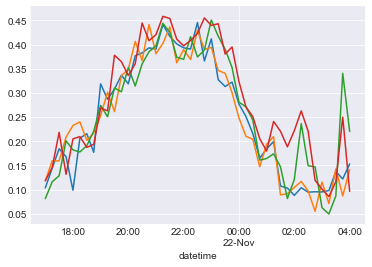

In [63]:
ps01.loc[(ps01.index >= starttime) & (ps01.index <= endtime) & (ps01.height == 3),'u*'].plot(label='PS01')
ps02.loc[(ps02.index >= starttime) & (ps02.index <= endtime) & (ps02.height == 3),'u*'].plot(label='PS02')
ps06.loc[(ps06.index >= starttime) & (ps06.index <= endtime) & (ps06.height == 3),'u*'].plot(label='PS06')
ps11.loc[(ps11.index >= starttime) & (ps11.index <= endtime) & (ps11.height == 3),'u*'].plot(label='PS11')
# ps01.loc[(ps01.index >= starttime) & (ps01.index <= endtime) & (ps01.height == 10),'u*'].plot(label='PS01',color='0.8')
# ps02.loc[(ps02.index >= starttime) & (ps02.index <= endtime) & (ps02.height == 10),'u*'].plot(label='PS02',color='0.8')
# ps06.loc[(ps06.index >= starttime) & (ps06.index <= endtime) & (ps06.height == 10),'u*'].plot(label='PS06',color='0.8')
# ps11.loc[(ps11.index >= starttime) & (ps11.index <= endtime) & (ps11.height == 10),'u*'].plot(label='PS11',color='0.8')

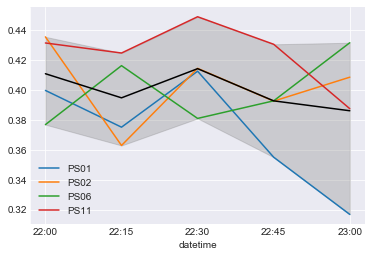

In [64]:
t0 = pd.to_datetime('2016-11-21 22:00')
t1 = pd.to_datetime('2016-11-21 23:00')
ustar_height = 10
ustar = pd.DataFrame({
    'PS01': ps01.loc[(ps01.index >= t0) & (ps01.index <= t1) & (ps01.height == ustar_height),'u*'],
    'PS02': ps02.loc[(ps02.index >= t0) & (ps02.index <= t1) & (ps02.height == ustar_height),'u*'],
    'PS06': ps06.loc[(ps06.index >= t0) & (ps06.index <= t1) & (ps06.height == ustar_height),'u*'],
    'PS11': ps11.loc[(ps11.index >= t0) & (ps11.index <= t1) & (ps11.height == ustar_height),'u*'],
})
ustar.to_csv('ustar_2016-11-21_2200.csv')

fig,ax = plt.subplots()
ustar.plot(ax=ax)

ustarmin = ustar.min(axis=1)
ustarmax = ustar.max(axis=1)
ustarmean = ustar.mean(axis=1)
ustarmean.plot(ax=ax,color='k')
ax.fill_between(ustar.index,ustarmin,ustarmax,color='0.5',alpha=0.3)

In [65]:
print(ps01.loc[(ps01.index >= simstart) & (ps01.index <= simend) & (ps01.height == 3),'u*'].mean())
print(ps02.loc[(ps02.index >= simstart) & (ps02.index <= simend) & (ps02.height == 3),'u*'].mean())
print(ps06.loc[(ps06.index >= simstart) & (ps06.index <= simend) & (ps06.height == 3),'u*'].mean())
print(ps11.loc[(ps11.index >= simstart) & (ps11.index <= simend) & (ps11.height == 3),'u*'].mean())

0.401568923668
0.394544841553
0.399925314977
0.424815881307


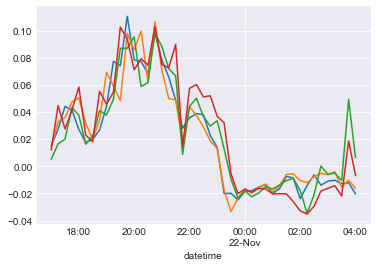

In [66]:
ps01.loc[(ps01.index >= starttime) & (ps01.index <= endtime) & (ps01.height == 3),'w/ts_cov'].plot(label='PS01')
ps02.loc[(ps02.index >= starttime) & (ps02.index <= endtime) & (ps02.height == 3),'w/ts_cov'].plot(label='PS02')
ps06.loc[(ps06.index >= starttime) & (ps06.index <= endtime) & (ps06.height == 3),'w/ts_cov'].plot(label='PS06')
ps11.loc[(ps11.index >= starttime) & (ps11.index <= endtime) & (ps11.height == 3),'w/ts_cov'].plot(label='PS11')
# ps01.loc[(ps01.index >= starttime) & (ps01.index <= endtime) & (ps01.height == 10),'w/ts_cov'].plot(label='PS01',color='0.8')
# ps02.loc[(ps02.index >= starttime) & (ps02.index <= endtime) & (ps02.height == 10),'w/ts_cov'].plot(label='PS02',color='0.8')
# ps06.loc[(ps06.index >= starttime) & (ps06.index <= endtime) & (ps06.height == 10),'w/ts_cov'].plot(label='PS06',color='0.8')
# ps11.loc[(ps11.index >= starttime) & (ps11.index <= endtime) & (ps11.height == 10),'w/ts_cov'].plot(label='PS11',color='0.8')

In [67]:
print(ps01.loc[(ps01.index >= simstart) & (ps01.index <= simend) & (ps01.height == 3),'w/ts_cov'].mean())
print(ps02.loc[(ps02.index >= simstart) & (ps02.index <= simend) & (ps02.height == 3),'w/ts_cov'].mean())
print(ps06.loc[(ps06.index >= simstart) & (ps06.index <= simend) & (ps06.height == 3),'w/ts_cov'].mean())
print(ps11.loc[(ps11.index >= simstart) & (ps11.index <= simend) & (ps11.height == 3),'w/ts_cov'].mean())

0.0298915963158
0.0285698325805
0.0389386626761
0.0515952773328


## check Obukhov stability

In [68]:
t0 = pd.to_datetime('2016-11-21 22:00')
t1 = pd.to_datetime('2016-11-21 23:00')
z_L = pd.DataFrame({
    'PS01': ps01.loc[(ps01.index >= t0) & (ps01.index <= t1) & (ps01.height == ustar_height),'z/L'],
    'PS02': ps02.loc[(ps02.index >= t0) & (ps02.index <= t1) & (ps02.height == ustar_height),'z/L'],
    'PS06': ps06.loc[(ps06.index >= t0) & (ps06.index <= t1) & (ps06.height == ustar_height),'z/L'],
    'PS11': ps11.loc[(ps11.index >= t0) & (ps11.index <= t1) & (ps11.height == ustar_height),'z/L'],
})
z_L.to_csv('z_L_2016-11-21_2200.csv')

fig,ax = plt.subplots()
z_L.plot(ax=ax)

z_L_min = z_L.min(axis=1)
z_L_max = z_L.max(axis=1)
z_L_mean = z_L.mean(axis=1)
z_L_mean.plot(ax=ax,color='k')
ax.fill_between(z_L.index,z_L_min,z_L_max,color='0.5',alpha=0.3)

KeyError: u'the label [z/L] is not in the [columns]'

## estimate starting potential temperature profile

In [ ]:
%%time
# by default, ESRL_wind_profiler expects a "WINDS" input
# need to set RASS-specific number of returns and the correct columns to QC
wasco_rass = wfip2.read_dir(dpath=wasco_dpath,
                            reader=ESRL_wind_profiler,
                            ext='.temp.txt',
                            modes=1,check_na=['T','Tc','W'])

wasco_rass = wasco_rass.set_index('date_time')

inrange = (wasco_rass.index >= starttime) & (wasco_rass.index <= endtime)
wasco_rass = wasco_rass.loc[inrange]

wasco_rass['height'] = wasco_rass['HT']*1000 # [m]
wasco_rass['temperature'] = wasco_rass['Tc'] + 273.15 # corrected consensus ~1hr-averaged temperature [K]

In [ ]:
wfip2.plot_temp(wasco_rass)
plt.title('temperature, NOT potential temperature')

estimate potential temperature

In [ ]:
# First-order approximation from Stull, Eqn. 1.5.1d
wasco_rass['theta_approx'] = wasco_rass['temperature'] + 0.0098*(wasco_rass['height'] + wasco_elev)
wfip2.plot_temp(wasco_rass,temperature_name='theta_approx')
format_time_axis(plt.gca())

In [ ]:
# Hypsometric equation 
#   Z2 - Z1 = Hmean * np.log(p1/p2)  (Wallace & Hobbs, Eqn. 3.29)
# or
#   p/p0 = exp(-z/H)
# where the scale height H ~= 8 km. The potential temperature can
# then be calculated with Poisson's equation:
#   theta = T*(p0/p)**(R/Cp)
H = 8000.0
p_p0 = np.exp(-(wasco_rass['height'] + wasco_elev) / H)
wasco_rass['theta_hyp'] = wasco_rass['temperature'] * (1.0/p_p0)**0.286
wfip2.plot_temp(wasco_rass,temperature_name='theta_hyp')
format_time_axis(plt.gca())

In [ ]:
theta_approx = wasco_rass.pivot(columns='height',values='theta_approx')
theta_hyp = wasco_rass.pivot(columns='height',values='theta_hyp')

idx = np.argmin(np.abs(theta_approx.index - pd.to_datetime(simstart)))
theta_approx = theta_approx.iloc[idx]
theta_hyp = theta_hyp.iloc[idx]

## Plots

In [ ]:
#fig,ax = plt.subplots(ncols=2, sharey=True, figsize=(8,6))
fig,ax = plt.subplots(ncols=3, sharey=True, figsize=(8,6))

ax[0].plot(Uradar, zradar, 's-', markersize=4, label='radar')
ax[0].plot(Usodar, zsodar, 's-', markersize=4, label='sodar')
ax[0].plot(Ulidar, zlidar, 's-', markersize=4, label='lidar')
ax[0].plot(Ups01, z01, 'o', label='met1')
ax[0].plot(Ups02, z02, 'o', label='met2')
ax[0].plot(Ups06, z06, 'o', label='met6')
ax[0].plot(Ups11, z11, 'o', label='met11')
p, = ax[0].plot(Ups12s, z12, 'o', label='met12(s)')
ax[0].errorbar(Ups12s, z12, xerr=Ups12s_std, color=p.get_color(), label='')
p, = ax[0].plot(Ups12w, z12, 'o', label='met12(w)')
ax[0].errorbar(Ups12w, z12, xerr=Ups12w_std, color=p.get_color(), label='')
ax[0].plot(Uprof,zprof, 'k-', label='power law\n(a={:.3f})'.format(alpha))
ax[0].set_xlabel('wind speed [m/s]')
ax[0].legend(loc='upper left')

ax[1].plot(WDradar, zradar, 's-', markersize=4, label='radar')
ax[1].plot(WDsodar, zsodar, 's-', markersize=4, label='sodar')
ax[1].plot(WDlidar, zlidar, 's-', markersize=4, label='lidar')
ax[1].plot(WDps01, z01, 'o', label='met1')
ax[1].plot(WDps02, z02, 'o', label='met2')
ax[1].plot(WDps06, z06, 'o', label='met6')
ax[1].plot(WDps11, z11, 'o', label='met11')
p, = ax[1].plot(WDps12s, z12, 'o', label='met12(s)')
ax[1].errorbar(WDps12s, z12, xerr=WDps12s_std, color=p.get_color(), label='')
p, = ax[1].plot(WDps12w, z12, 'o', label='met12(w)')
ax[1].errorbar(WDps12w, z12, xerr=WDps12w_std, color=p.get_color(), label='')
ax[1].axvline(WDref, color='k', ls='--')
ax[1].set_xlabel('wind direction [deg]')

ax[2].plot(theta_approx.values, theta_approx.index)
ax[2].plot(theta_hyp.values, theta_hyp.index)

ax[0].set_ylim((0,1000))
ax[0].set_ylabel('height AGL [m]')
